In [176]:
# Standard 
import numpy as np
import pandas as pd

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Utility
import time

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Import clean data

In [177]:
# Load csv-file and display 5 first rows
data = pd.read_csv("clean.csv", sep = ",", index_col="Unnamed: 0")
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0


# Data for RandomForestClassifier

In [178]:
forest_data = data.copy()

# RandomForestClassifier()

In [179]:
rf = RandomForestClassifier(
    random_state=123, 
    max_depth=6, 
    min_samples_split= 5,
    n_estimators=100
    )

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

# Prepare data for RandomForestClassifier

In [180]:
X = forest_data.drop(["Outcome"], axis = 1)
y = forest_data["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y, test_size=0.2)

rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

# Test results

In [181]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        88
           1       0.73      0.55      0.63        40

    accuracy                           0.80       128
   macro avg       0.77      0.73      0.74       128
weighted avg       0.79      0.80      0.79       128



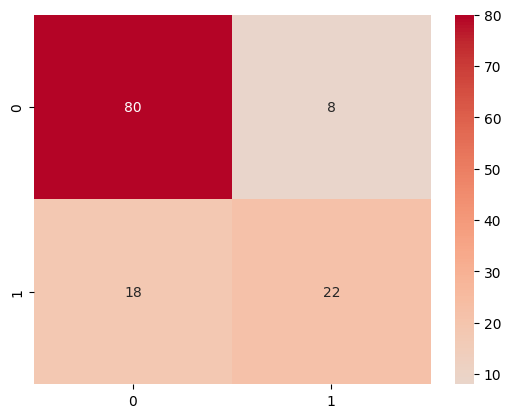

In [193]:
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
sns.heatmap(data = cm, cmap="coolwarm", center = 0, annot=True)
plt.show()